In [100]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from DGLim.data import *
import librosa
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2

In [101]:
def swap_in_true_mag(x, mag):
    '''
    For the short time fourier transform, to work with batched data
    we need to remove the channel dimension and add it back after. We
    still need an 4D tensor for the DNN to work properly. This means,
    that the dimension needs to be reduced after the swap and expanded
    again before the DNN. This entire cell is just a conformation, that
    this is the necessary proceedure. 
    '''
    phase = torch.angle(x)
    # return torch.cat([mag * torch.cos(phase), mag * torch.sin(phase)], dim=1) # legacy
    return  (mag + 1j * phase).squeeze_(1)


x = torch.randn(16,1,513,1024, dtype=torch.complex64)
mag = torch.randn(16,1,513,1024, dtype=torch.float32)

out = swap_in_true_mag(x,mag)
print(f'OUT SHAPE: {out.shape}')
print(f'OUT TYPE: {out.dtype}')


istft = torch.istft(out, n_fft=1024, hop_length=512, win_length=1024)
print(f'ISTFT shape: {istft.shape}')
print(f'ISTFT dtype: {istft.dtype}')

stft = torch.stft(istft, n_fft=1024, hop_length=512, win_length=1024,return_complex=True)
print(f'STFT shape: {stft.shape}')
print(f'STFT dtype: {stft.dtype}')

# print(f'unsqueezed stft shape: {stft.unsqueeze_(1).shape}')

OUT SHAPE: torch.Size([16, 513, 1024])
OUT TYPE: torch.complex64
ISTFT shape: torch.Size([16, 523776])
ISTFT dtype: torch.float32
STFT shape: torch.Size([16, 513, 1024])
STFT dtype: torch.complex64


In [102]:
def visualize_complex_tensor(tensor):
    if tensor.isinstance(torch.Tensor):
        tensor = tensor.detach()
    else:
        pass
    # Separate the real and imaginary parts of the complex tensor
    real = tensor.abs()
    imag = tensor.angle()
    amptodb = torchaudio.transforms.AmplitudeToDB()

    # Create a grid of subplots for real and imaginary parts
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the real part
    im1 = axs[0].imshow(amptodb(real), cmap='magma')
    axs[0].set_title('Mag')

    # Plot the imaginary part
    im2 = axs[1].imshow(imag, cmap='Blues')
    axs[1].set_title('Phase')

    # Add color bar
    fig.colorbar(im1, ax=axs[0])
    fig.colorbar(im2, ax=axs[1])

    # Show the plot
    plt.show()

In [103]:
class convGLU(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, kernel_size=(7,7), padding='same', batchnorm=False):
        super().__init__()
        if padding == 'same':
            padding = (kernel_size[0]//2, kernel_size[1]//2)
        self.conv = nn.Conv2d(in_channels, out_channels * 2, kernel_size, padding=padding)  # 2D convolutional layer
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function
        if batchnorm:
            self.conv = nn.Sequential(
                self.conv,
                nn.BatchNorm2d(out_channels * 2)  # Batch normalization layer
            )

    def forward(self, x):
        x = self.conv(x)  # Apply convolutional layer
        channel = x.shape[1]  # Get the number of channels

        x = x[:, :channel//2, :, :] * self.sigmoid(x[:, channel//2:, :, :])  # Apply GLU (Gated Linear Unit)
        return x
    

class DNN(nn.Module):
    def __init__(self,padding=None,additional_conv=False):
        super().__init__()
        self._hidden_channels = 32
        self.initial = nn.Sequential(
            nn.Conv2d(7, self._hidden_channels, (11,11), padding=padding) if additional_conv else nn.Identity(), # in_channel = 6 because we concatenate the real and imag part of the complex spectrogram
            convGLU(self._hidden_channels if additional_conv else 7, self._hidden_channels, (11,11), padding='same'))
        
        self.mid = nn.Sequential(
            nn.Conv2d(self._hidden_channels, self._hidden_channels, (7,3), padding=(7//2, 3//2)) if additional_conv else nn.Identity(),
            convGLU(self._hidden_channels, self._hidden_channels, (7,3), padding='same'),
            nn.Conv2d(self._hidden_channels, self._hidden_channels, (7,3), padding=(7//2, 3//2)) if additional_conv else nn.Identity(),
            convGLU(self._hidden_channels, self._hidden_channels, (7,3), padding='same'),
        )

        self.final = nn.Sequential(
            nn.Conv2d(self._hidden_channels, 1, (7,3), padding=(7//2, 3//2)) if additional_conv else nn.Identity(),
            convGLU(self._hidden_channels,self._hidden_channels, (7,3), padding='same'),
            nn.Conv2d(self._hidden_channels, 2, (7,3), padding=(7//2, 3//2)),
        )

    def forward(self, x):
        x = self.initial(x)
        residual = x
        x = self.mid(x)
        x += residual
        x = self.final(x)
        return x


class DeepGriffinLim(nn.Module):
    def __init__(self,blocks=10, n_fft=1024, hop_size=512, win_size=1024, window='hann_window'):
        super().__init__()
        self.dnn_blocks = nn.ModuleList([DNN() for _ in range(blocks)]) # DNN blocks

    def stft(self, x, n_fft=1024, hop_size=512, win_size=1024):
        return torch.stft(x, n_fft=n_fft, hop_length=hop_size, win_length=win_size, return_complex=True)

    def istft(self, x, n_fft=1024, hop_size=512, win_size=1024):
        return torch.istft(x, n_fft=n_fft, hop_length=hop_size, win_length=win_size)

    def magswap(self, mag, x_tilda):
        return mag * x_tilda / torch.abs(x_tilda)

    def forward(self,x_tilda, mag, added_depth=1):

        subblock_out = []
        for _ in range(added_depth):
            for subblock in self.dnn_blocks:
                
                # step one is the P_a step
                y_tilda = self.magswap(mag=mag,x_tilda=x_tilda)
                z_tilda = self.stft(self.istft(y_tilda.squeeze(1)))

                dnn_in = self.transform_to_float([x_tilda, y_tilda, z_tilda.unsqueeze(1)])
                dnn_in = torch.cat([dnn_in, mag], dim=1)

                dnn_out = subblock(dnn_in)
                residual  = torch.complex(dnn_out[:,0,...], dnn_out[:,1,...])

                x_tilda = (z_tilda - residual).unsqueeze_(1)

                subblock_out.append(residual)

                
        final = self.magswap(mag=mag,x_tilda=x_tilda)
        return z_tilda.unsqueeze_(1), residual.unsqueeze_(1), final, subblock_out

    @staticmethod
    def transform_to_float(tensor_list: list):
        output = []
        for idx, i in enumerate(range(len(tensor_list))):
            if tensor_list[i].dtype == torch.complex64 and tensor_list[i].dim() == 4:
                output.append(torch.cat([tensor_list[i].real, tensor_list[i].imag], dim=1))
            else:
                print(f'Input {idx} is not a complex tensor with 4 dimensions')
                return None

        return torch.cat(output, dim=1)
        



In [105]:
model = DeepGriffinLim()


noise = torch.randn((2,1,513,100),dtype=torch.complex64)
mag = torch.randn((2,1,513,100),dtype=torch.float32)


z_tilda, residual, final, subblock_out = model(x_tilda=noise,mag=mag)

print(z_tilda.shape)

torch.Size([2, 1, 513, 100])


In [77]:
from torch.utils.data import Dataset, DataLoader

In [90]:
def convert_from_complex(tens):
    """Converts a complex tensor to a real tensor"""
    return torch.cat((torch.abs(tens), torch.angle(tens)), dim=1)

In [107]:
# Hyperparams
epochs = 25
learning_rate = 5e-4
weight_decay = 0.0001

train_data = DataLoader(ds, batch_size=hp.batch_size, shuffle=True, num_workers=hp.num_workers)

model = DeepGriffinLim(blocks=10)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.L1Loss(reduction='sum')


batch = next(iter(train_data))

for epoch in range(epochs):
    clear, noisy, mag, label = batch
    # Forward pass
    
    z_tilda, residual, final, subblock_out = model(x_tilda=noisy, mag=mag)

    z_tilda_for_loss = convert_from_complex(z_tilda)
    residual_for_loss = convert_from_complex(residual)
    clear_for_loss = convert_from_complex(clear)

    # Compute loss
    loss = criterion(z_tilda_for_loss[:,1:,...] - clear_for_loss[:,1:,...], residual_for_loss[:,1:,...])

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    print(f'Epoch: {epoch} Loss: {loss.item()}')



    




Epoch: 0 Loss: 1096376.375
Epoch: 1 Loss: 907623.3125
Epoch: 2 Loss: 802982.3125
Epoch: 3 Loss: 732750.4375
Epoch: 4 Loss: 689892.9375
Epoch: 5 Loss: 671239.5
Epoch: 6 Loss: 674041.0
Epoch: 7 Loss: 680432.75
Epoch: 8 Loss: 682413.5625
Epoch: 9 Loss: 680006.3125
Epoch: 10 Loss: 676040.625
Epoch: 11 Loss: 671311.125
Epoch: 12 Loss: 666467.5625
Epoch: 13 Loss: 661622.5
Epoch: 14 Loss: 657294.25
Epoch: 15 Loss: 654016.375
Epoch: 16 Loss: 651279.4375
Epoch: 17 Loss: 649013.6875
Epoch: 18 Loss: 646739.0
Epoch: 19 Loss: 644056.625
Epoch: 20 Loss: 641881.6875
Epoch: 21 Loss: 639673.375
Epoch: 22 Loss: 637589.4375
Epoch: 23 Loss: 635669.625
Epoch: 24 Loss: 633705.3125


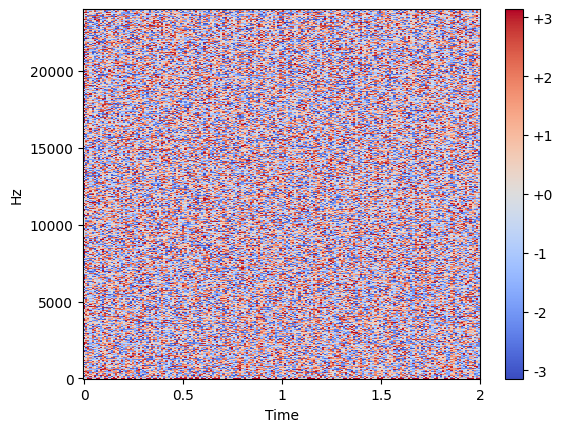

In [111]:
phase_2 = torch.angle(final)

phase = torch.angle(clear)

librosa.display.specshow((phase[0][0]).detach().numpy(),

    sr=48000,
    x_axis='time',
    y_axis='linear',
    # vmin=0,
    # vmax=44100//2
    )
plt.colorbar(format="%+2.f")
plt.show() 

In [112]:
import numpy as np

def compute_derivatives(phase_spectrogram):
    # Compute the differences along the time axis (axis=1)
    psi_if = np.diff(phase_spectrogram, axis=1)
    # Add a column of zeros at the end to keep the same size
    psi_if = np.hstack([psi_if, np.zeros((psi_if.shape[0], 1))])
    
    # Compute the differences along the frequency axis (axis=0)
    psi_gd = np.diff(phase_spectrogram, axis=0)
    # Add a row of zeros at the end to keep the same size
    psi_gd = np.vstack([psi_gd, np.zeros((1, psi_gd.shape[1]))])

    # Wrap the differences to the range -pi to pi
    psi_if = np.mod(psi_if + np.pi, 2 * np.pi) - np.pi
    psi_gd = np.mod(psi_gd + np.pi, 2 * np.pi) - np.pi

    return psi_if, psi_gd


In [116]:
phase[0][0].numpy()

array([[ 0.0000000e+00,  0.0000000e+00,  3.1415925e+00, ...,
         0.0000000e+00,  3.1415925e+00,  3.1415925e+00],
       [ 9.0972552e-10, -1.3811070e+00,  2.3805029e+00, ...,
        -3.8180721e-01, -2.2703898e+00,  1.2124178e+00],
       [ 3.1415925e+00,  1.8744237e+00,  6.5030795e-01, ...,
        -2.8253276e+00, -2.8794143e+00, -2.7028620e+00],
       ...,
       [ 4.1396760e-07, -2.8755791e+00,  3.8808900e-01, ...,
        -3.5538796e-01,  2.1691825e+00,  3.0797422e-01],
       [ 2.9499779e-07,  2.1016159e+00, -1.2023507e+00, ...,
        -7.5599676e-01, -2.8276784e+00,  4.0211320e-01],
       [ 0.0000000e+00,  3.1415925e+00,  3.1415925e+00, ...,
         3.1415925e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

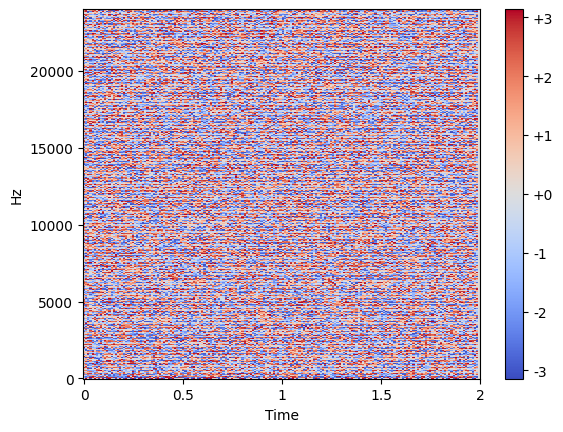

In [124]:
ifq, gd = compute_derivatives(phase[0][0].numpy())

librosa.display.specshow(ifq,

    sr=48000,
    x_axis='time',
    y_axis='linear',
    # vmin=0,
    # vmax=44100//2
    )
plt.colorbar(format="%+2.f")
plt.show() 